# **Acquiring images**

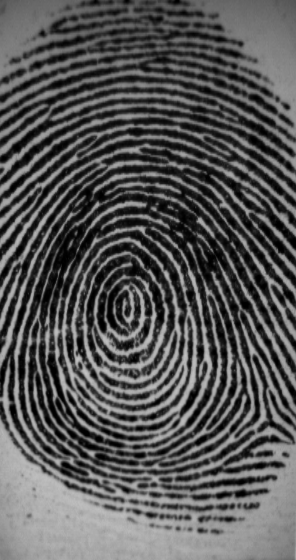

In [2]:
import matplotlib.pyplot as plt
import scipy
from skimage.color import rgb2gray
import cv2
from math import sqrt
import numpy as np
import math
from skimage.morphology import skeletonize as skelt
from google.colab.patches import cv2_imshow

img = cv2.imread("101_5.tif", 0)
cv2_imshow(img)

# **Image segmentation**

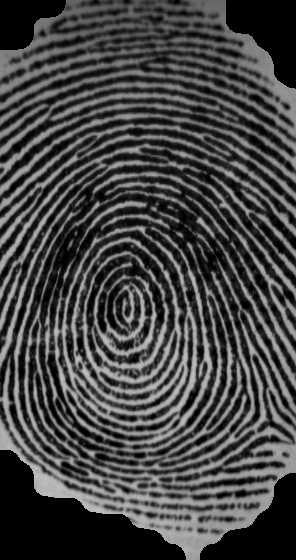

In [9]:
def imgSegmentation(image, blockSize, threshold): 
    (y, x) = image.shape
    threshold = np.mean(image) * threshold

    imageSTDs = np.zeros(image.shape)
    segmentedImage = image.copy()
    mask = np.ones_like(image)

    for i in range(0, x, blockSize):
        for j in range(0, y, blockSize):
            box = [i, j, min(i + blockSize, x), min(j + blockSize, y)]
            imageSTDs[box[1]:box[3], box[0]:box[2]] = np.std(image[box[1]:box[3], box[0]:box[2]])

    # apply threshold
    mask[imageSTDs < threshold] = 0
    
    # smooth mask with a open/close morphological filter
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (blockSize * 2, blockSize * 2))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    segmentedImage *= mask

    return segmentedImage, mask

(segmented, mask) = imgSegmentation(img, 16, 0.1)
cv2_imshow(segmented)

# **Calculate Orientation field**

In [4]:
def calculate_angles(image, blockSize):
    (y, x) = image.shape
    result = [[] for i in range(1, y, blockSize)]

    sobel = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    ySobel = np.array(sobel)
    xSobel = np.transpose(ySobel)

    imageGX = cv2.filter2D(image/127,-1, ySobel)
    imageGY = cv2.filter2D(image/127,-1, xSobel)


    # Whole image loop
    for j in range(1, y, blockSize):
        for i in range(1, x, blockSize):
            Vx = 0
            Vy = 0

            # Block loop
            for u in range(j, min(j + blockSize, y - 1)):
                for v in range(i, min(i + blockSize, x - 1)):
                    Gx = imageGX[u, v]
                    Gy = imageGY[u, v] 
                    Vx += 2 * Gx * Gy
                    Vy += Gx ** 2 - Gy ** 2

            # zero numerator/denominator prevention
            if Vx and Vy:
                angle = (math.pi + math.atan2(Vx, Vy)) / 2
                result[(j - 1) // blockSize].append(angle)
            else:
                result[(j - 1) // blockSize].append(0)
    result = np.array(result)
    return result


angles = calculate_angles(img, 16)

# **Frequency map**

In [5]:
def blockFrequency(imageBlock, angleBlock, kernelSize, minWaveLength, maxWaveLength):
    # Rotate the image block so that the ridges are vertical
    rotatedImage = scipy.ndimage.rotate(imageBlock, angleBlock / np.pi * 180 + 90, reshape=False,mode='nearest')

    # Sum down the columns to get a projection of the grey values down the ridges.
    ridgeSum = np.sum(rotatedImage, axis=0)
    dilation = scipy.ndimage.grey_dilation(ridgeSum, kernelSize, structure=np.ones(kernelSize))
    ridgeNoise = np.abs(dilation - ridgeSum)
    threshold = 2
    maxpts = (ridgeNoise < threshold) & (ridgeSum > np.mean(ridgeSum))
    maxind = np.where(maxpts)
    _, no_of_peaks = np.shape(maxind)

    if (no_of_peaks < 2):
        freqBlock = np.zeros(imageBlock.shape)
    else:
        waveLength = (maxind[0][-1] - maxind[0][0]) / (no_of_peaks - 1)
        if waveLength >= minWaveLength and waveLength <= maxWaveLength:
            freqBlock = 1 / np.double(waveLength) * np.ones(imageBlock.shape)
        else:
            freqBlock = np.zeros(imageBlock.shape)
    return freqBlock


def ridgeFrequency(image, mask, angles, blockSize, kernelSize, minWaveLength, maxWaveLength):
    x, y = image.shape
    freq = np.zeros((x, y))

    for row in range(0, x - blockSize, blockSize):
        for col in range(0, y - blockSize, blockSize):
            imageBlock = image[row:row + blockSize][:, col:col + blockSize]
            angleBlock = angles[row // blockSize][col // blockSize]
            freq[row:row + blockSize][:, col:col + blockSize] = blockFrequency(imageBlock, angleBlock, kernelSize,
                                                                               minWaveLength, maxWaveLength)

    freq_1d = freq.flatten()
    ind = np.where(freq_1d > 0)
    ind = np.array(ind)
    nonZeroFrequencies = freq_1d[ind]
    medianfreq = np.median(nonZeroFrequencies) * mask

    return medianfreq

freq = ridgeFrequency(segmented, mask, angles, 16, 5, minWaveLength=5, maxWaveLength=15)

# **Gabor filter**

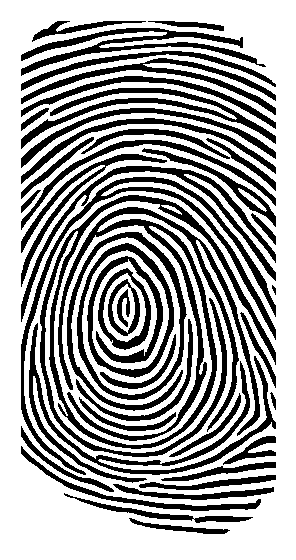

In [7]:
def gaborFilter(image, angle, freq):
    angleInc = 1
    image = np.double(image)
    rows, cols = image.shape
    result = np.zeros((rows, cols))
    contrastFactor = 0.65 # determines the degree of contrast enhancement
    smoothingFactor = 0.65 # determines the smoothing of the ridges

    freq_1d = freq.flatten()
    ind = np.array(np.where(freq_1d > 0))
    nonZeroFrequencies = freq_1d[ind]
    unfreq = np.unique(nonZeroFrequencies)

    # Generate filters corresponding to frequency and
    # orientations while angle increments.
    sigma_x = contrastFactor / unfreq
    sigma_y = smoothingFactor / unfreq
    block_size = int(np.round(3 * np.max([sigma_x, sigma_y])))
    array = np.linspace(-block_size, block_size, (2 * block_size + 1))
    x, y = np.meshgrid(array, array)

    # gabor filter equation
    reffilter = np.exp(-((np.power(x, 2)) / (sigma_x * sigma_x) + (np.power(y, 2)) / (sigma_y * sigma_y))) * np.cos(
        2 * np.pi * unfreq[0] * x)
    filt_rows, filt_cols = reffilter.shape
    gaborFilterBank = np.array(np.zeros((180 // angleInc, filt_rows, filt_cols)))

    # Generate rotated versions of the filter.
    for degree in range(0, 180 // angleInc):
        rotatedFilter = scipy.ndimage.rotate(reffilter, -(degree * angleInc + 90), reshape=False)
        gaborFilterBank[degree] = rotatedFilter

    orientindex = np.round(angle / np.pi * 180)

    # Find indices of matrix points greater than block size from the image boundary
    block_size = int(block_size)
    valid_row, valid_col = np.where(freq > 0)
    finalind = np.where((valid_row > block_size) & (valid_row < rows - block_size) & (valid_col > block_size) & ( valid_col < cols - block_size))

    for k in range(0, np.shape(finalind)[1]):
        r = valid_row[finalind[0][k]]
        c = valid_col[finalind[0][k]]
        img_block = image[r - block_size:r + block_size + 1][:, c - block_size:c + block_size + 1]
        result[r][c] = np.sum(img_block * gaborFilterBank[int(orientindex[r // 16][c // 16]) - 1])

    gaborImg = 255 - np.array((result < 0) * 255).astype(np.uint8)

    return gaborImg


gabor_img = gaborFilter(img, angles, freq)
cv2_imshow(gabor_img)

# **Skeletonization**

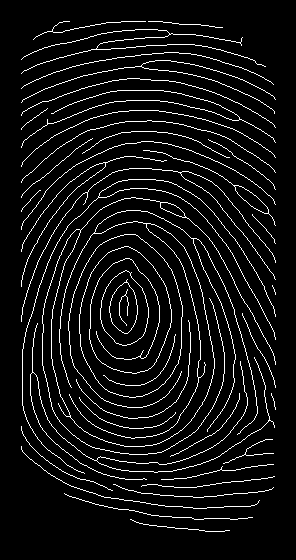

In [202]:
def skeletonize(image_input):
    image = np.zeros_like(image_input)
    image[image_input == 0] = 1
    output = np.zeros_like(image_input)

    skeleton = skelt(image)

    output[skeleton] = 255

    return output

thin_image = skeletonize(gabor_img)
cv2_imshow(thin_image)

# **Minutiae detection**

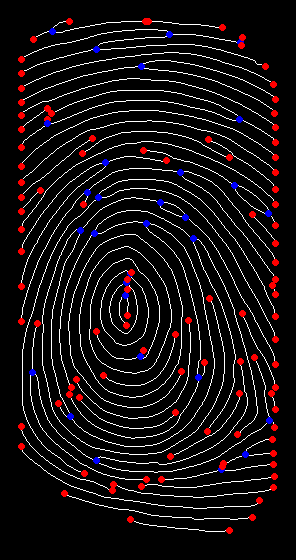

In [203]:
def minutiae_at(pixels, i, j, kernel_size):

    # if middle pixel is black (represents ridge)
    if pixels[i][j] == 1:
        cells = [(-1, -1), (-1, 0), (-1, 1),        # p1 p2 p3
               (0, 1),  (1, 1),  (1, 0),            # p8    p4
              (1, -1), (0, -1), (-1, -1)]           # p7 p6 p5


        values = [pixels[i + l][j + k] for k, l in cells]

        # count crossing how many times it goes from 0 to 1
        crossings = 0
        for k in range(0, len(values)-1):
            crossings += abs(values[k] - values[k + 1])
        crossings //= 2

        if crossings == 1:
            return "terminal"
        if crossings == 3:
            return "bifurcation"

    return "none"


def calculate_minutiaes(im, kernel_size=3):
    binary_image = np.zeros_like(im)
    binary_image[im==255] = 1.0
    binary_image = binary_image.astype(np.int8)

    (y, x) = im.shape
    result = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    colors = {"terminal" : (0, 0, 255), "bifurcation" : (255, 0, 0)}

    # iterate each pixel minutia
    for i in range(1, x - kernel_size//2):
        for j in range(1, y - kernel_size//2):
            minutiae = minutiae_at(binary_image, j, i, kernel_size)
            if minutiae != "none":
                cv2.circle(result, (i,j), radius=2, color=colors[minutiae], thickness=2)

    return result

minutias = calculate_minutiaes(thin_image)
cv2_imshow(minutias)